In [18]:
import os
from skimage.io import imread, imshow, imsave
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.draw import line
from skimage.morphology import skeletonize
import pymorph
import mahotas as mh
from scipy import spatial
from bresenham import bresenham
import pandas as pd
import networkx as nx
import cv2
import numpy as np
from collections import deque
from scipy.ndimage import label, find_objects
import pickle

def skel_to_graph(skeIm, connectivity=2):
    assert(len(skeIm.shape) == 2)
    skeImPos = np.stack(np.where(skeIm))
    skeImPosIm = np.zeros_like(skeIm, dtype=np.int32)
    skeImPosIm[skeImPos[0], skeImPos[1]] = np.arange(0, skeImPos.shape[1])
    g = nx.Graph()
    if connectivity == 1:
        neigh = np.array([[0, 1], [0, -1], [1, 0], [-1, 0]])
    elif connectivity == 2:
        neigh = np.array([[0, 1], [0, -1], [1, 0], [-1, 0], [1, 1], [1, -1], [-1, 1], [-1, -1]])
    else:
        raise ValueError(f'unsupported connectivity {connectivity}')
    for idx in range(skeImPos[0].shape[0]):
        for neighIdx in range(neigh.shape[0]):
            curNeighPos = skeImPos[:, idx] + neigh[neighIdx]
            if np.any(curNeighPos<0) or np.any(curNeighPos>=skeIm.shape):
                continue
            if skeIm[curNeighPos[0], curNeighPos[1]] > 0:
                g.add_edge(skeImPosIm[skeImPos[0, idx], skeImPos[1, idx]], skeImPosIm[curNeighPos[0], curNeighPos[1]], weight=np.linalg.norm(neigh[neighIdx]))
    return g


def skeletonizer(img):
    (thresh, bw) = cv2.threshold(img, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    skeleton_lee = skeletonize(bw, method='lee')
    return skeleton_lee

def branchedPoints(skel):
    branch1=np.array([[2, 1, 2], [1, 1, 1], [2, 2, 2]])
    branch2=np.array([[1, 2, 1], [2, 1, 2], [1, 2, 1]])
    branch3=np.array([[1, 2, 1], [2, 1, 2], [1, 2, 2]])
    branch4=np.array([[2, 1, 2], [1, 1, 2], [2, 1, 2]])
    branch5=np.array([[1, 2, 2], [2, 1, 2], [1, 2, 1]])
    branch6=np.array([[2, 2, 2], [1, 1, 1], [2, 1, 2]])
    branch7=np.array([[2, 2, 1], [2, 1, 2], [1, 2, 1]])
    branch8=np.array([[2, 1, 2], [2, 1, 1], [2, 1, 2]])
    branch9=np.array([[1, 2, 1], [2, 1, 2], [2, 2, 1]])
    br1=mh.morph.hitmiss(skel,branch1)
    br2=mh.morph.hitmiss(skel,branch2)
    br3=mh.morph.hitmiss(skel,branch3)
    br4=mh.morph.hitmiss(skel,branch4)
    br5=mh.morph.hitmiss(skel,branch5)
    br6=mh.morph.hitmiss(skel,branch6)
    br7=mh.morph.hitmiss(skel,branch7)
    br8=mh.morph.hitmiss(skel,branch8)
    br9=mh.morph.hitmiss(skel,branch9)
    return br1+br2+br3+br4+br5+br6+br7+br8+br9

def endPoints(skel):
    endpoint1=np.array([[0, 0, 0],
                        [0, 1, 0],
                        [2, 1, 2]])
    
    endpoint2=np.array([[0, 0, 0],
                        [0, 1, 2],
                        [0, 2, 1]])
    
    endpoint3=np.array([[0, 0, 2],
                        [0, 1, 1],
                        [0, 0, 2]])
    
    endpoint4=np.array([[0, 2, 1],
                        [0, 1, 2],
                        [0, 0, 0]])
    
    endpoint5=np.array([[2, 1, 2],
                        [0, 1, 0],
                        [0, 0, 0]])
    
    endpoint6=np.array([[1, 2, 0],
                        [2, 1, 0],
                        [0, 0, 0]])
    
    endpoint7=np.array([[2, 0, 0],
                        [1, 1, 0],
                        [2, 0, 0]])
    
    endpoint8=np.array([[0, 0, 0],
                        [2, 1, 0],
                        [1, 2, 0]])
    
    endpoint9=np.array([[0, 0, 0],
                        [0, 1, 0],
                        [0, 0, 0]])
    
    ep1=mh.morph.hitmiss(skel,endpoint1)
    ep2=mh.morph.hitmiss(skel,endpoint2)
    ep3=mh.morph.hitmiss(skel,endpoint3)
    ep4=mh.morph.hitmiss(skel,endpoint4)
    ep5=mh.morph.hitmiss(skel,endpoint5)
    ep6=mh.morph.hitmiss(skel,endpoint6)
    ep7=mh.morph.hitmiss(skel,endpoint7)
    ep8=mh.morph.hitmiss(skel,endpoint8)
    ep9=mh.morph.hitmiss(skel,endpoint9)
    ep = ep1+ep2+ep3+ep4+ep5+ep6+ep7+ep8+ep9
    return ep
def pruning(skeleton, size):

    for i in range(0, size):
        endpoints = endPoints(skeleton)
        endpoints = np.logical_not(endpoints)
        skeleton = np.logical_and(skeleton,endpoints)
    return skeleton

def shuffle(a):
    a = list(a)
    random.shuffle(a)
    return a 
def normalize(arr, upper_bound=255, uint8 = True):
    if arr.max() != arr.min():
        if uint8:
            return ((arr - arr.min())*(upper_bound/(arr.max()-arr.min()))).astype('uint8')
        else:
            return (arr - arr.min())*(upper_bound/(arr.max()-arr.min()))
    else:
        if uint8:
            return arr.astype('uint8')
        else: 
            return arr

def detect_tails2(mask, ep_val=3, bp_vals=[2], out_px_value=5, min_line_length=10):
    mask_bi = cv2.threshold(mask, 0, 1, 8)
    mask = mask_bi[1]
    skel = mh.thin(mask)
    skel = pruning(skel,3)
    bp = branchedPoints(skel)
    ep = endPoints(skel)
    edge = skel-bp
    bps = np.where(bp>0, 1, 0)
    eps = np.where(ep>0, 2, 0)
    combined = bps+eps+skel #ep_val becomes 3 here as a result of combination
    data = combined.copy()
    ep_coords = np.argwhere(data == ep_val)
    lines=dict()
    for p in ep_coords:
        lines.update({f'{list(p)}':[]})
    for point in ep_coords:
        center = point
        lines[f'{list(center)}'].append(list(point))
        no_bp = True
        counter = 0
        while no_bp:
            counter+=1
            tl = [point[0]-1, point[1]-1]
            t = [point[0]-1, point[1]]
            tr = [point[0]-1, point[1]+1]
            l = [point[0], point[1]-1]
            c = [point[0], point[1]]
            r = [point[0], point[1]+1]
            bl = [point[0]+1, point[1]-1]
            b = [point[0]+1, point[1]]
            br = [point[0]+1, point[1]+1]
            ker = [t, r, b, l]
            try:
                for j in ker:
                    if (data[j[0], j[1]] ==1) & (list(j) not in lines[f'{list(center)}']):
                        lines[f'{list(center)}'].append(list(j))
                        point = j
                    elif data[j[0], j[1]] in bp_vals: #branch points
                        no_bp = False
                if counter > len(data):
                    no_bp = False
            except:
                no_bp = False
    filterred_lines = {}
    eliminated_lines = {}
    for key in lines.keys():
        for p in lines[key]:
            if len(lines[key])>=3:
                if len(lines[key])>=min_line_length:
                    data[p[0],p[1]] = out_px_value
                    filterred_lines.update({key:lines[key]})
                else:
                    data[p[0],p[1]] = 0
                    ind = list(np.array(key.replace(' ', '').replace('[', '').replace(']', '').split(',')).astype(int))
                    combined[ind[0], ind[1]]=4
                    eliminated_lines.update({key:lines[key]})
            else:
                data[p[0],p[1]] = 0
                
    return combined, data, filterred_lines, eliminated_lines


def closeness_loss2(mask, min_line_length=1):
    img, data, lines, eliminated_lines = detect_tails2(mask, ep_val=3, bp_vals=[2], out_px_value=5, min_line_length=min_line_length)
    leaves = len(np.where(img==3)[0])
    branch_points = len(np.where(img==2)[0])
    if branch_points != 0:
        ratio = (leaves/branch_points)*10
        y = 1-(np.e**(-3*ratio))
    else:
        y = 1
    return [leaves, len(np.where(img==1)[0]), ratio, y]

def dynamic_threshold(mask):
    if len(mask.shape) == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary_mask

def collapse_twos(grid):
    grid0 = grid.copy()
    structure = np.ones((3, 3), dtype=int)  
    labeled_array, num_features = label(grid == 2, structure=structure)
    for i in range(1, num_features + 1):
        slices = find_objects(labeled_array == i)[0]
        top_left = (slices[0].start, slices[1].start)
        grid[labeled_array == i] = 0
        grid[top_left] = 2
    grid1 = np.where((grid + grid0)>3,1,0) + np.where(grid0>0,1,0)
    return grid1

def pad_one(image):
    image[0, :] = 255
    image[-1, :] = 255
    image[:, 0] = 255
    image[:, -1] = 255
    return image

import numpy as np
from collections import deque
from scipy.ndimage import label, find_objects
import networkx as nx

def proximity_checker(mask, point, start, end):
    tl = [point[0]-1, point[1]-1]
    t = [point[0]-1, point[1]]
    tr = [point[0]-1, point[1]+1]
    l = [point[0], point[1]-1]
    c = [point[0], point[1]]
    r = [point[0], point[1]+1]
    bl = [point[0]+1, point[1]-1]
    b = [point[0]+1, point[1]]
    br = [point[0]+1, point[1]+1]
    ker = [t, r, b, l, tl, tr, bl, br]
    flag = False
    for j in ker:
        if 0 <= j[0] < mask.shape[0] and 0 <= j[1] < mask.shape[1]:
            if (mask[j[0], j[1]] ==2) & ((j[0], j[1]) != end) & ((j[0], j[1]) != start):
                flag = True
    return flag

def bfs(start, end, grid):
    if start == end:
        return True
    rows, cols = grid.shape
    queue = deque([start])
    visited = set()
    visited.add(start)
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (1,1), (-1,1), (1,-1), (-1,-1)]
    while queue:
        x, y = queue.popleft()
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < rows and 0 <= ny < cols and (nx, ny) not in visited and not proximity_checker(grid, (nx, ny), start, end):
                if (nx, ny) == end:
                    return True
                if grid[nx][ny] == 1:
                    visited.add((nx, ny))
                    queue.append((nx, ny))
    return False

def find_connections(grid):
    vertices = np.argwhere(grid == 2)
    results = []
    for i in range(len(vertices)):
        for j in range(i + 1, len(vertices)):
            if bfs(tuple(vertices[i]), tuple(vertices[j]), grid):
                results.append((tuple(vertices[i]), tuple(vertices[j]), 1))
            else:
                results.append((tuple(vertices[i]), tuple(vertices[j]), 0))
    return results

def create_graph(connections):
    G = nx.Graph()
    for start, end, connected in connections:
        if connected:
            G.add_edge(start, end)
    nodes = set([node for edge in connections for node in edge[:2]])
    for node in nodes:
        if node not in G:
            G.add_node(node)
    pos = {node: (node[1], -node[0]) for node in nodes}  # Position nodes based on their grid positions
#     nx.draw(G, pos, with_labels=False, node_color='skyblue', node_size=50, edge_color='k')
#     plt.show()
    return G, pos

def grapher(tp, out, clean=False, pad=True):
    tim = imread(tp)
    inp = dynamic_threshold(tim)
    p = tp.split('/')[-1]
    if pad:
        inp = pad_one(inp)
        
    a, b, c, d = detect_tails2(inp, ep_val=3, bp_vals=[2], out_px_value=5, min_line_length=0)
            
    if clean:
        b2 = np.where(b==5, 0 , b)
    else:
        b2 = np.where(a==1, 1, 0)+np.where(a>1, 2, 0)
        
    b2_collapsed = collapse_twos(b2.copy())
    connections_tp = find_connections(b2_collapsed)
    G, pos_tp = create_graph(connections_tp)
    with open(f'graphs/{out}/graph/{p[:-4]}.pickle', 'wb') as f:
        pickle.dump(G, f)
    imsave(f'graphs/{out}/mask/{p[:-4]}.png', b2_collapsed)

t_paths = os.listdir('/mmfs1/home/jacks.local/mohsen.ahmadkhani/imageprocessing/singan/outputs/Output_615/RandomSamples/clover175x240/gen_start_scale=0')
count = 0
with open('count_log.txt', 'a') as filelog:
    for p in t_paths:
        if p.endswith('m.png'):
            count += 1
            filelog.write(f'{count}, ')
            filelog.flush()  

            tp = f"topo/gen_start_scale=0/{p}"
            grapher(tp, out="padded_cleaned_topo", clean=True, pad=True)
            grapher(tp, out="padded_dirty_topo", clean=False, pad=True)
            grapher(tp, out="cleaned_topo", clean=True, pad=False)
            
            sp = f"simple/gen_start_scale=0/{p}"
            grapher(sp, out="padded_dirty_simple", clean=False, pad=True)



FileNotFoundError: No such file: '/mmfs1/home/jacks.local/mohsen.ahmadkhani/imageprocessing/singan/singan/SinGAN/topo/gen_start_scale=0/3_m.png'

In [17]:
pwd

'/mmfs1/home/jacks.local/mohsen.ahmadkhani/imageprocessing/singan/singan/SinGAN'

In [16]:
import cupy

In [32]:
# torch.median(xx)
torch.sigmoid??
adjusted_input = sharpness * (x - threshold)


NameError: name 'sharpness' is not defined

In [33]:
!pwd

/mmfs1/home/jacks.local/mohsen.ahmadkhani/imageprocessing/singan/singan/SinGAN


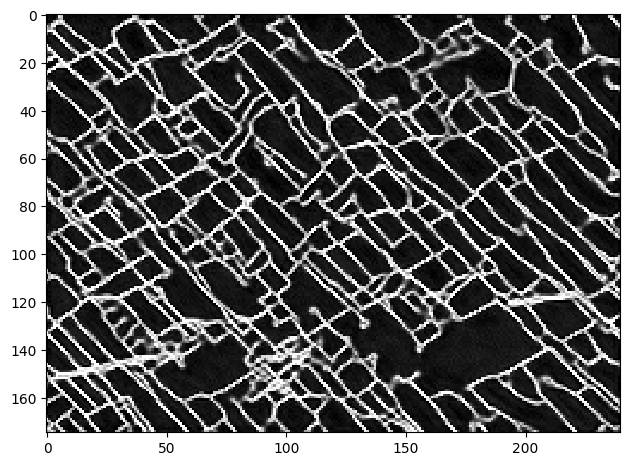

In [119]:
num = 1624
# num = 611
# num = 853
# num = 725
s = 8
p = f"/mmfs1/home/jacks.local/mohsen.ahmadkhani/imageprocessing/singan/params/TrainedModels/TrainedModels_{num}/clover175x240/scale_factor=0.75,alpha=10/{s}/fake_sample.png"
pim = imread(p)
imshow(pim[:,:,3])

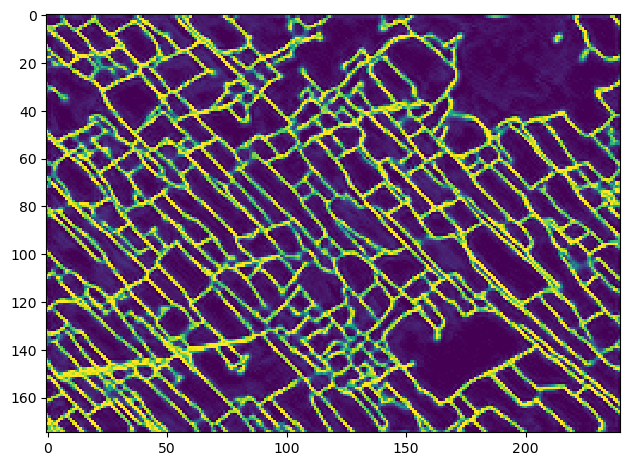

In [11]:
num = 472
# num = 1928 --bad
num = 1382
# num = 763 #bad
# num = 1472 #bad
num = 1624
num = 611 # terible
num = 853
num = 725
num = 615 # Perfect
# num = 548 #1-5-2 terrible

n = 2
mode = 'm'
p = f"/mmfs1/home/jacks.local/mohsen.ahmadkhani/imageprocessing/singan/outputs/Output_{num}/RandomSamples/clover175x240/gen_start_scale=0/{n}_{mode}.png"
pim = imread(p)
imshow(pim[:,:,:])

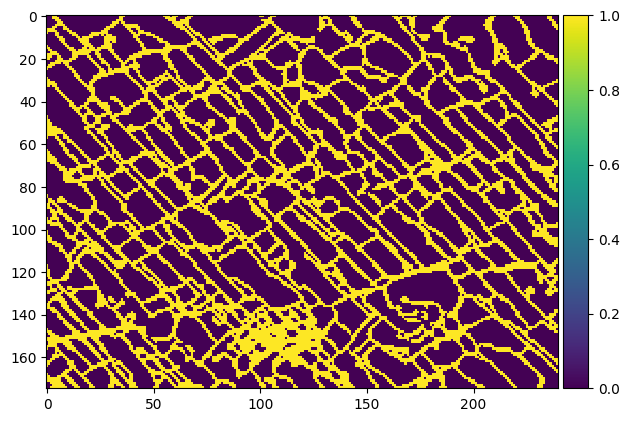

In [80]:
mask = pim[:,:,1]

imshow(np.where(mask>80, 1, 0))

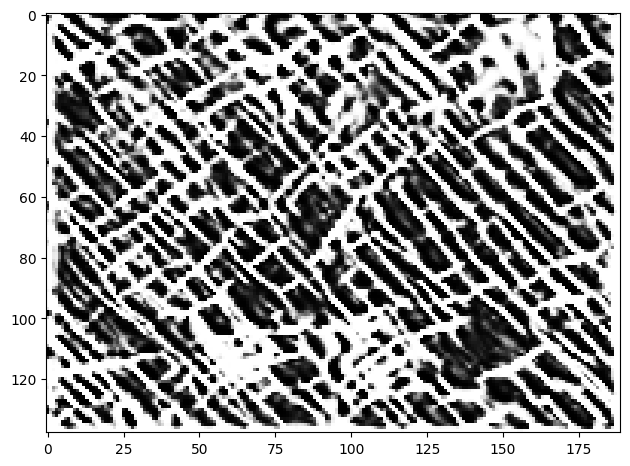

In [30]:
p = "/mmfs1/home/jacks.local/mohsen.ahmadkhani/imageprocessing/singan/params/temp/fake_xx_7.pth"

xx = torch.load(p)
# adjusted_input = 20 * (xx - torch.median(xx))
siged = torch.sigmoid(20 * (xx - torch.median(xx)))
cpued = siged.detach().cpu().numpy()[0][0]


imshow(cpued)

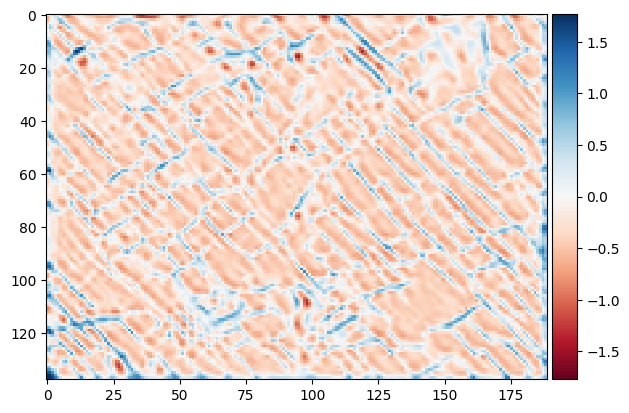

In [12]:
imshow(xx.detach().cpu().numpy()[0][0])

In [11]:
!sinfo

/bin/bash: line 1: sinfo: command not found


In [10]:
!module load slurm

In [127]:
import torch
print(torch.version.cuda)


11.8
